In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

In [2]:
raw_df = pd.read_csv('../input/creditcardfraud/creditcard.csv')
labels=["Genuine","Fraud"]

fraud_or_not = raw_df["Class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=raw_df['Class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["grey","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

In [3]:
df = raw_df.copy()

df.drop_duplicates(inplace=True)
print("Duplicated values dropped succesfully")

Duplicated values dropped succesfully


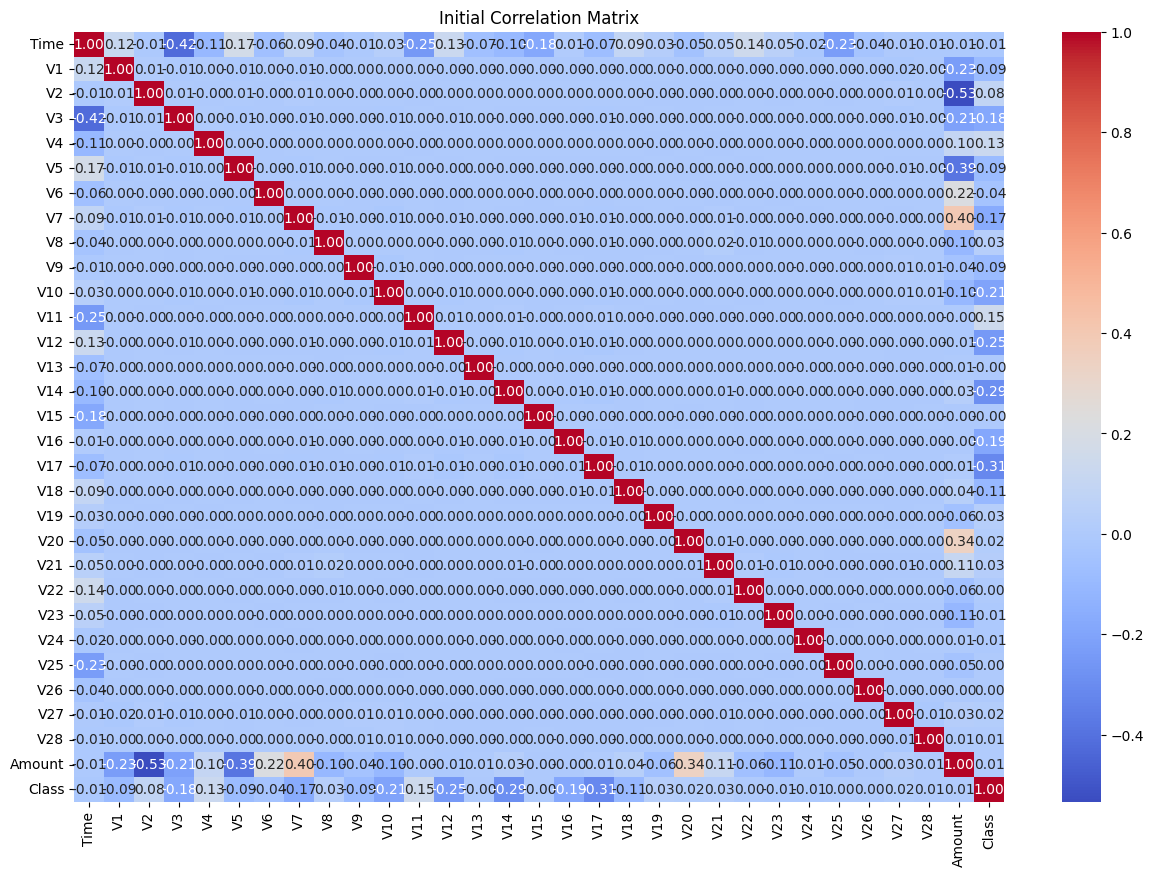

In [4]:
corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Initial Correlation Matrix")
plt.show()

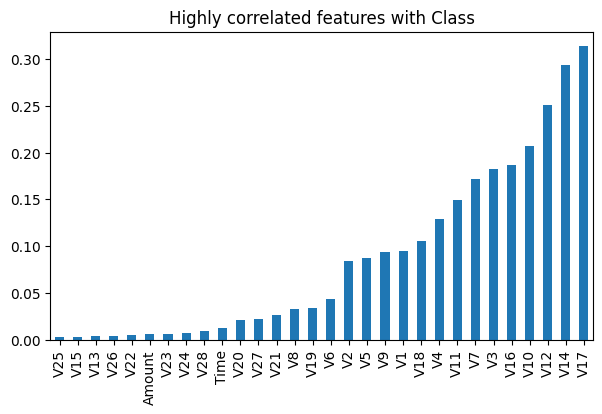

In [5]:
plt.figure(figsize=(7,4))
d = df.corr()['Class'][:-1].abs().sort_values().plot(kind='bar', title='Highly correlated features with Class')

In [6]:
numeric_columns = (list(df.loc[:, 'V1':'Amount']))
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [7]:
# detecting outliers
Outliers_IQR = IQR_method(df,1,numeric_columns)

# dropping outliers
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 31685


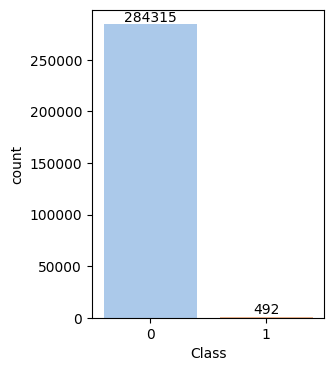

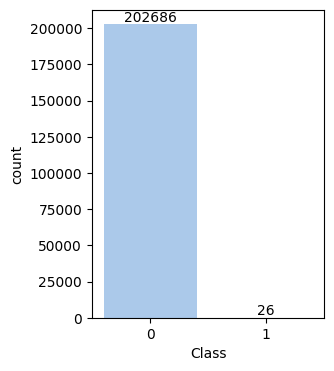

In [8]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Class',data=raw_df,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Class',data=df_out,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)


In [9]:
# Calculate the absolute correlations
correlations = df.corr()['Class'][:-1].abs()

# Filter the features with correlation less than 0.10
features_to_drop = correlations[correlations < 0.10].index

# Drop the features from the DataFrame
df = df.drop(columns=features_to_drop)

In [10]:
from sklearn.preprocessing import RobustScaler

# Separate the target variable and features
X = df.drop(columns=['Class'])
y = df['Class']

# Initialize the scaler (use RobustScaler instead of StandardScaler)
scaler = RobustScaler()

# Fit the scaler to the data and transform the features
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame for better readability
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [11]:
from sklearn.model_selection import train_test_split
# Split the resampled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled_df, y, stratify=y, test_size=0.2, random_state=42)

In [12]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import cross_val_score

# # # Define the parameter grid
# # param_dist = {
# #     'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
# #     'n_estimators': [50, 100, 150, 200],
# #     'max_depth': [3, 5, 7, 10],
# #     'subsample': [0.8, 0.9, 1],
# #     'colsample_bytree': [0.8, 0.9, 1],
# #     'gamma': [0, 0.1, 0.2, 0.3, 0.4],
# #     'alpha': [0, 0.1, 0.2, 0.3, 0.4],
# #     'lambda': [0.5, 1, 1.5, 2]
# # }
# #Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'lambda': 0.5, 'gamma': 0.3, 'colsample_bytree': 1, 'alpha': 0.4}
# ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
# xgb_model = XGBClassifier(
#     scale_pos_weight=ratio,
#     objective="binary:logistic",
#     random_state=42,
#     eval_metric="auc",
#     max_depth= 10, 
#     learning_rate= 0.05,
#     gamma= 0.3,
#     alpha= 0.3
# )

# # # Initialize RandomizedSearchCV
# # random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=100, scoring='roc_auc', cv=5, verbose=3, random_state=42)
# # # Fit the model
# # random_search.fit(X_train, y_train)

# # # Get the best parameters and score
# # best_params = random_search.best_params_
# # best_score = random_search.best_score_

# # print(f"Best Parameters: {best_params}")
# # print(f"Best AUC Score: {best_score}")

In [13]:
# from sklearn.ensemble import BaggingClassifier

# bagging_clf = BaggingClassifier(estimator=xgb_model, n_estimators= 10, random_state=42)
# bagging_clf.fit(X_train, y_train)

In [14]:
# calibrated_probs = bagging_clf.predict_proba(X_val)[:, 1]
# results_df = X_val.copy()
# results_df['Predicted_Probability'] = calibrated_probs
# from sklearn.metrics import roc_auc_score, brier_score_loss, average_precision_score

# # Calculate Brier Score
# brier = brier_score_loss(y_val, calibrated_probs)
# print(f"Brier Score: {brier:.4f}")

# auc = roc_auc_score(y_val, calibrated_probs)
# print(f"AUC: {auc:.4f}")

In [15]:
!pip install pennylane --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 62.4 MB/s eta 0:00:00


In [16]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
from scipy.sparse import bsr_matrix
import pennylane as qml
import numpy as np

from sklearn.model_selection import train_test_split # data split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt

In [17]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


In [18]:
# # Hybrid Classical-Quantum Neural Network

# #---------Classical Layer 1----------
# clayer_1 = tf.keras.layers.Dense(2, activation="sigmoid")
# print("Classical layer 1 created")


# #--------Quantum Layer----------
# n_qubits = 2
# dev = qml.device("default.qubit", wires=n_qubits)

# @qml.qnode(dev)
# def qnode(inputs, weights):
#     qml.AngleEmbedding(inputs, wires=range(n_qubits))
#     qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
#     return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# n_layers = 6
# weight_shapes = {"weights": (n_layers, n_qubits)}

# qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
# print("Quantum layer created")


# #---------Classical Layer 2-----------
# clayer_2 = tf.keras.layers.Dense(1, activation="sigmoid")
# print("Classical layer 2 created")


# #Create the hybrid model
# model = tf.keras.models.Sequential([clayer_1, qlayer, clayer_2])
# print("Quantum and classical layers added")

In [19]:
# opt = tf.keras.optimizers.SGD(learning_rate=0.01)
# model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])
# history = model.fit(X_train, y_train, batch_size = 32, epochs = 20,validation_split=0.2)

In [20]:
#---------Classical Layer 1----------
clayer_1 = tf.keras.layers.Dense(2, activation="sigmoid")
#---------Classical Layer 2-----------
clayer_2 = tf.keras.layers.Dense(1, activation="sigmoid")
model = tf.keras.models.Sequential([clayer_1,clayer_2])

In [21]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])
history = model.fit(X_train, y_train, batch_size = 32, epochs = 20,validation_split=0.2)

Epoch 1/20
5675/5675 [==============================] - 14s 2ms/step - loss: 0.0512 - auc: 0.8350 - val_loss: 0.0156 - val_auc: 0.9586
Epoch 2/20
5675/5675 [==============================] - 12s 2ms/step - loss: 0.0125 - auc: 0.9388 - val_loss: 0.0107 - val_auc: 0.9544
Epoch 3/20
5675/5675 [==============================] - 12s 2ms/step - loss: 0.0099 - auc: 0.9385 - val_loss: 0.0092 - val_auc: 0.9542
Epoch 4/20
5675/5675 [==============================] - 11s 2ms/step - loss: 0.0089 - auc: 0.9451 - val_loss: 0.0086 - val_auc: 0.9515
Epoch 5/20
5675/5675 [==============================] - 12s 2ms/step - loss: 0.0084 - auc: 0.9430 - val_loss: 0.0082 - val_auc: 0.9528
Epoch 6/20
5675/5675 [==============================] - 11s 2ms/step - loss: 0.0081 - auc: 0.9408 - val_loss: 0.0079 - val_auc: 0.9471
Epoch 7/20
5675/5675 [==============================] - 11s 2ms/step - loss: 0.0078 - auc: 0.9414 - val_loss: 0.0078 - val_auc: 0.9473
Epoch 8/20
5675/5675 [==============================] -

1774/1774 [==============================] - 2s 1ms/step
Confusion Matrix:
[[56651     0]
 [   95     0]]
ROC-AUC: 0.9615546341449819


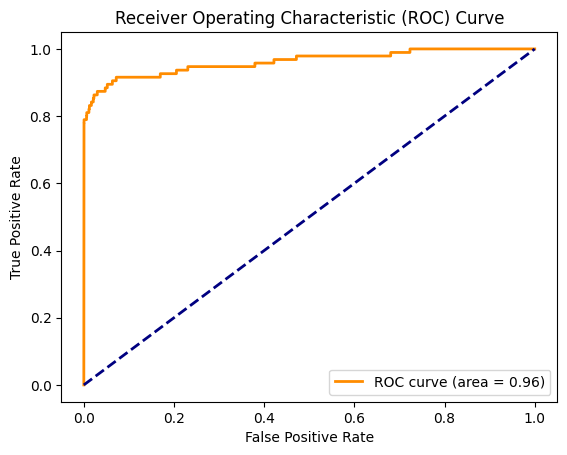

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import AUC

# # Assuming you have your model, X_test, and y_test
# # Modify this section with your actual model and test data

# # Example Model
# model = Sequential()
# model.add(Dense(units=64, activation='relu', input_dim=100))
# model.add(Dense(units=1, activation='sigmoid'))
# model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=[AUC()])

# # Generate some example data (replace this with your actual test data)
# X_test = np.random.rand(100, 100)
# y_test = np.random.randint(2, size=(100,))

# # Train-test split for demonstration
# X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

# # Train the model
# history = model.fit(X_train, y_train, batch_size=10, epochs=10, validation_data=(X_val, y_val))

# Predict on the test set
y_pred = model.predict(X_val)

# Compute the confusion matrix
cm = confusion_matrix(y_val, (y_pred > 0.5).astype(int))
print("Confusion Matrix:")
print(cm)

# Compute the ROC-AUC score
roc_auc = roc_auc_score(y_val, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [23]:
# import keras
# from keras import backend as K
# from keras.models import Sequential
# from keras.layers import Activation
# from keras.layers.core import Dense
# from keras.optimizers import Adam
# from keras.metrics import categorical_crossentropy

# n_inputs = X_train.shape[1]

# undersample_model = Sequential([
#     Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
#     Dense(32, activation='relu'),
#     # Change this layer to have a single output neuron for binary classification
#     Dense(1, activation='sigmoid')
# ])
# opt = tf.keras.optimizers.SGD(learning_rate=0.01)
# NN_model.compile(optimizer=opt, 
#                  loss="binary_crossentropy", 
#                  metrics=[tf.keras.metrics.AUC()])
# NN_model.fit(X_train, y_train, batch_size=10, epochs=3, validation_split=0.2, shuffle=True, verbose=2)